# <a id='1'>1. Import Modules </a>

In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
import warnings
warnings.filterwarnings('ignore') # Suppress warnings
from scipy import stats
from scipy.stats import norm, skew
%matplotlib inline

# <a id='2'>2. Data Loading </a>

In [2]:
application_train = pd.read_csv('application_train.csv')
df_train = application_train.copy()

In [4]:
(df_train.shape)

(307511, 122)

# <a id='3'>3. Glimpse of Data</a>

In [5]:
df_train.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# <a id='4'> 4 Check for missing data</a>

In [6]:
total = df_train.isnull().sum().sort_values(ascending=False)
percentage = (df_train.isnull().sum()/df_train.isnull().count()*100).sort_values(ascending=False)
missing_train_data = pd.concat([total, percentage], axis=1, keys=['Total', 'Percentage'])
missing_train_data.head(5)

,Total,Percentage
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963


# <a id='5'>5. Data Exploration</a>

<a id='5-1'>5.1 Feature: TARGET</a>

In [7]:
target = df_train['TARGET']
target.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

The feature 'TARGET' is what this Machine Learning problem is about. We are trying to predict the value of the feature 'TARGET' by using other related features associated with the client's personal, professional, and credit history. 

Let's have a look at the distribution of the feature 'TARGET' in the Training dataset. The 'TARGET' feature has the value '0' (will repay loan on time) for 282.686 observations and the value '1' (will have difficulty repaying loan) for 24,825 observations.

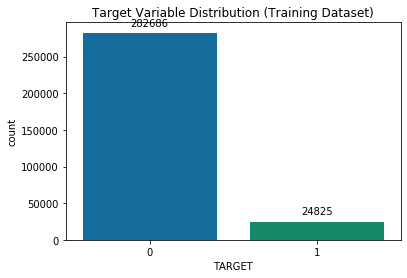

In [35]:
plt.ylabel('Instances')
plt.xlabel('TARGET value')
plt.title('Target Variable Distribution (Training Dataset)')
plot = sns.countplot(x='TARGET', data=df_train)
for p in plot.patches:
    plot.annotate(format(p.get_height(), 'd'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    

In [9]:
target.value_counts()[0]/(target.value_counts()[0]+target.value_counts()[1])

0.9192711805431351

As shown on the chart above, we see this is an imbalanced class problem. There are clearly many more loans that were repaid on time than loans that were not repaid. Indeed, observations with 'TARGET' value at 0 constitue 91.9% of the Training dataset. 

Machine learning algorithms typically work best when the number of instances of each classes are roughly equal. We will have to address this target feature imbalance prior to implementing our Machine Learning algorithms.

<a id='5-2'>5.2 Feature of 'DAYS_BIRTH'</a>

The feature 'DAYS_BIRTH' describes Client's age in days at the time of the application. The values of the feature are negative and the correlation factor is positive which means that as the client gets older, they are less likely to default on their loan. Let's plot the distribution of the 'DAYS_BIRTH' feature in the Training datasets.

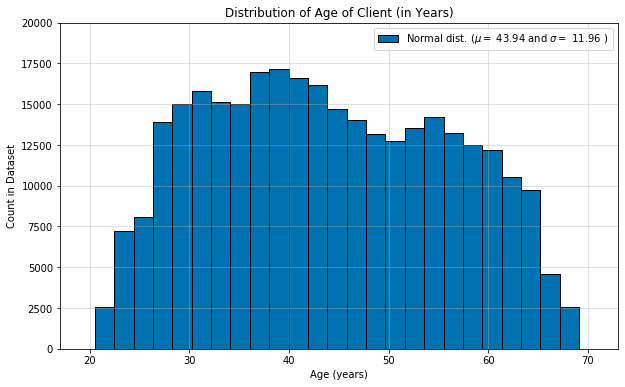

In [10]:
# Plot the distribution of ages in years
age_years = df_train['DAYS_BIRTH'] / -365
plt.figure(figsize=(10,6))
plt.style.use('seaborn-colorblind')
plt.grid(True, alpha=0.5)
plt.hist(age_years, edgecolor = 'k', bins = 25)
plt.xlim(17,73)
plt.ylim(0,20000)
(mu, sigma) = norm.fit(age_years)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.title('Distribution of Age of Client (in Years)')
plt.xlabel('Age (years)')
plt.ylabel('Count in Dataset');

To get a better representation of the distribution, let's split the data in DAYS_BIRTH to represent the distribution of Repaid (Target=0) and Not Repaid (Target=1) Loans as a funciton of the Client's Age. To do this, we'll create a kernel density estimation plot (KDE) colored by the value of the target. A kernel density estimation (KDE) is a non-parametric way to estimate the probability density function of a random variable. It will allow us to identify if there is a correlation between the Age of the Client and their ability to pay it back.

As we can see below, the plot indicates that the ratio of loans not repaid (Target=1) decreases as the client ages. In other words, the client's ability to repay their loan seems to improve with the client's age.

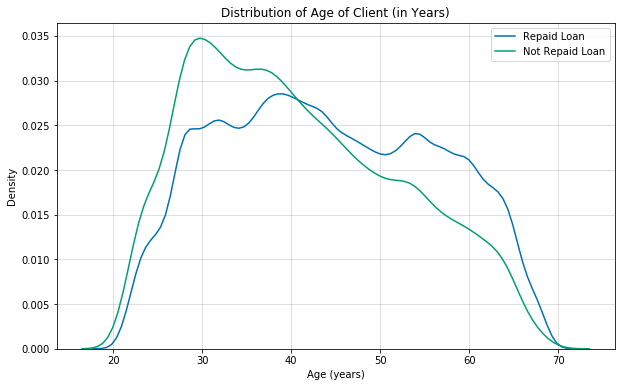

In [12]:
plt.figure(figsize=(10,6))
plt.style.use('seaborn-colorblind')
plt.grid(True, alpha=0.5)
sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, 'DAYS_BIRTH'] / -365, label = 'Repaid Loan')
sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, 'DAYS_BIRTH'] / -365, label = 'Not Repaid Loan')
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Age of Client (in Years)');

This is further emphasized in the plot below, in which the unrepaid loans (Target=1) are grouped together in brackets corresponding go the Client's Age. The plot clearly indicates that as the client ages, the rate of unpaid loan decreases.

In [13]:
# Age information into a separate dataframe
age_data = df_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data.loc[:,'DAYS_BIRTH'].copy() / -365
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups.drop(['DAYS_BIRTH'], axis=1, inplace=True)

Text(0.5, 1.0, "Failure to Repay by Client's Age Range")

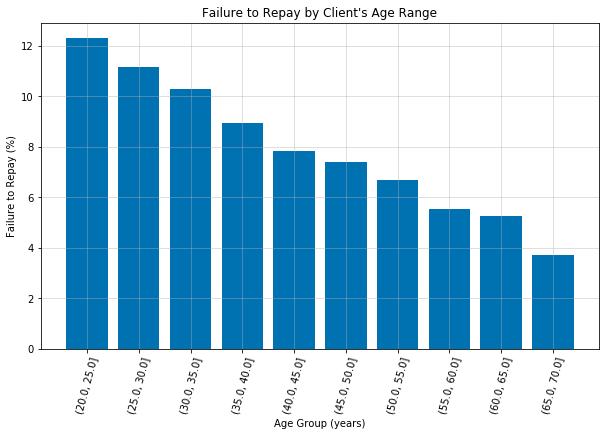

In [34]:
plt.figure(figsize=(10,6))
plt.style.use('seaborn-colorblind')
plt.grid(True, alpha=0.5)
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])
plt.xticks(rotation = 75)
plt.xlabel('Age Group (years)')
plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Client\'s Age Range')

<a id='5-3'>5.3 Feature of 'NAME_CONTRACT_TYPE'</a>

The feature 'NAME_CONTRACT_TYPE' identifies if loan is cash or revolving. The vast majority of loans were 'Cash' loans, at 90.5% of loans in the Training set.

In [21]:
df_train['NAME_CONTRACT_TYPE'].value_counts()

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

In [24]:
df_train[df_train['NAME_CONTRACT_TYPE'] == 'Cash loans']['TARGET'].value_counts()

0    255011
1     23221
Name: TARGET, dtype: int64

In [25]:
23221*100/278232

8.345912763449208

In [26]:
df_train[df_train['NAME_CONTRACT_TYPE'] == 'Revolving loans']['TARGET'].value_counts()

0    27675
1     1604
Name: TARGET, dtype: int64

In [27]:
1604*100/29279

5.478329177909082

The chart below shows the types and contracts in the training set by target value. The ratio of loans not repaid (Target =1) for Cash loans is 8.35%, while the ratio of loans not repaid (Target =1) for Revolding loans is 5.48%.

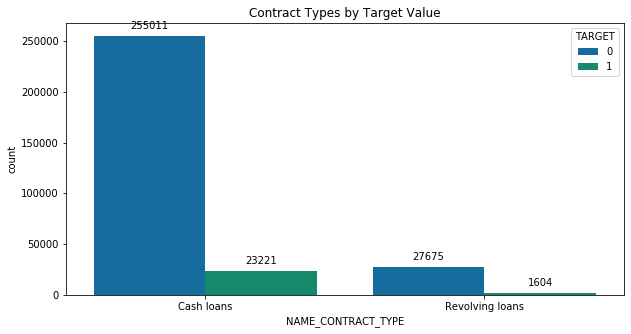

In [31]:
# Count Plot (a.k.a. Bar Plot)
plt.figure(figsize=(10,5))
plt.ylabel('Count')
plt.title('Contract Types by Target Value')
splot = sns.countplot(x='NAME_CONTRACT_TYPE', hue='TARGET', data=df_train)
for p in splot.patches:
    splot.annotate(format(p.get_height(), 'd'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    

<a id='5-3'>5.3 Feature of 'AMT_CREDIT'</a>

The 'AMT_CREDIT' feature describes the credit amount of the loan. As can be seen in the plot below, the distribution of repair and not repaid loans follow a similar distribution. Certain brackets of loans, for instance the range of loans between 400,000 and 600,000 have a higher ration of not repaid loans.

Text(0.5, 1.0, 'Distribution of Amount of Credit by Target Value')

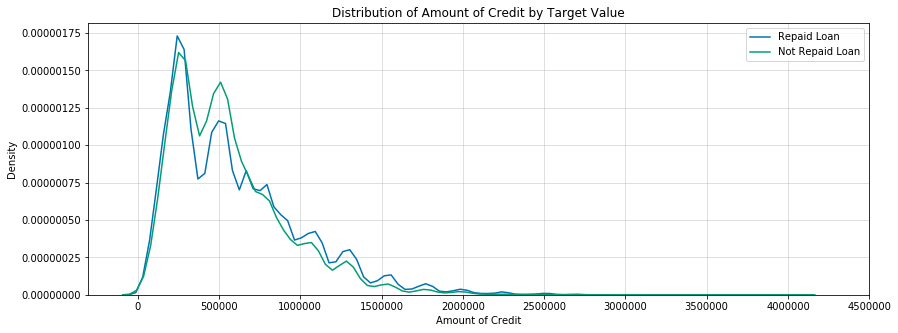

In [36]:
plt.figure(figsize=(14,5))
plt.style.use('seaborn-colorblind')
plt.grid(True, alpha=0.5)
sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, 'AMT_CREDIT'], 
            label = 'Repaid Loan')
sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, 'AMT_CREDIT'], 
            label = 'Not Repaid Loan')
plt.xlabel('Amount of Credit')
plt.xticks(np.arange(0, 5000000, 500000))
plt.ylabel('Density')
plt.title('Distribution of Amount of Credit by Target Value')

<a id='5-3'>5.3 Feature of 'DAYS_EMPLOYED'</a>

The 'DAYS_EMPLOYED' feature describes how many days before the application the person started current employment. As can be seen in the plot below, the distribution of Not Repaid Loans peaks at DAYS_EMPLOYED around zero. Values equal to and below zero are likely to indicate that the individual is unemployed. 

Hence that would impact that individual's ability to repair their loans. The ability of an individual to repair their loan seems to be positively correlated to the duration of employment at their current job.

Text(0.5, 1.0, 'Distribution of Amount of Credit by Target Value')

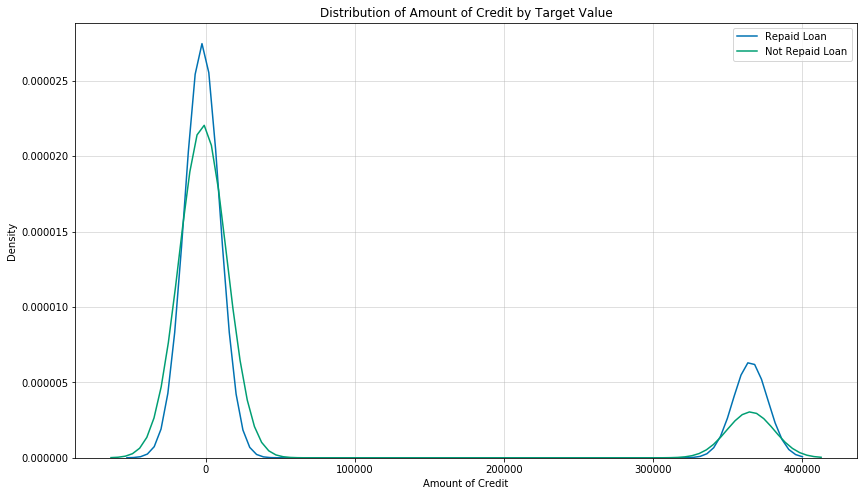

In [37]:
plt.figure(figsize=(14,8))
plt.style.use('seaborn-colorblind')
plt.grid(True, alpha=0.5)
sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, 'DAYS_EMPLOYED'], 
            label = 'Repaid Loan')
sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, 'DAYS_EMPLOYED'], 
            label = 'Not Repaid Loan')
plt.xlabel('Amount of Credit')
plt.ylabel('Density')
plt.title('Distribution of Amount of Credit by Target Value')

# <a id='6'>6. Correlation</a>

Let's take a look at some of more significant correlations. Let's focus on top most strongly correlated factors with the feature 'TARGET'. As shown below, these features are related to the Region where the client is from as well the Exteral Sources 1, 2 and 3. These correspond to normalized score from external data sources.

In [38]:
# Find correlations with the target and sort
correlations = df_train.corr()['TARGET'].sort_values()
print('Most Positive Correlations: \n', correlations.tail(5))
print('\nMost Negative Correlations: \n', correlations.head(5))

Most Positive Correlations: 
 DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations: 
 EXT_SOURCE_3    -0.178919
EXT_SOURCE_2    -0.160472
EXT_SOURCE_1    -0.155317
DAYS_EMPLOYED   -0.044932
FLOORSMAX_AVG   -0.044003
Name: TARGET, dtype: float64


In [39]:
df_train_corr = df_train[['TARGET','DAYS_BIRTH','REGION_RATING_CLIENT_W_CITY','REGION_RATING_CLIENT',
                          'DAYS_LAST_PHONE_CHANGE','FLOORSMAX_AVG','DAYS_EMPLOYED','EXT_SOURCE_1', 
                          'EXT_SOURCE_2', 'EXT_SOURCE_3']].copy()

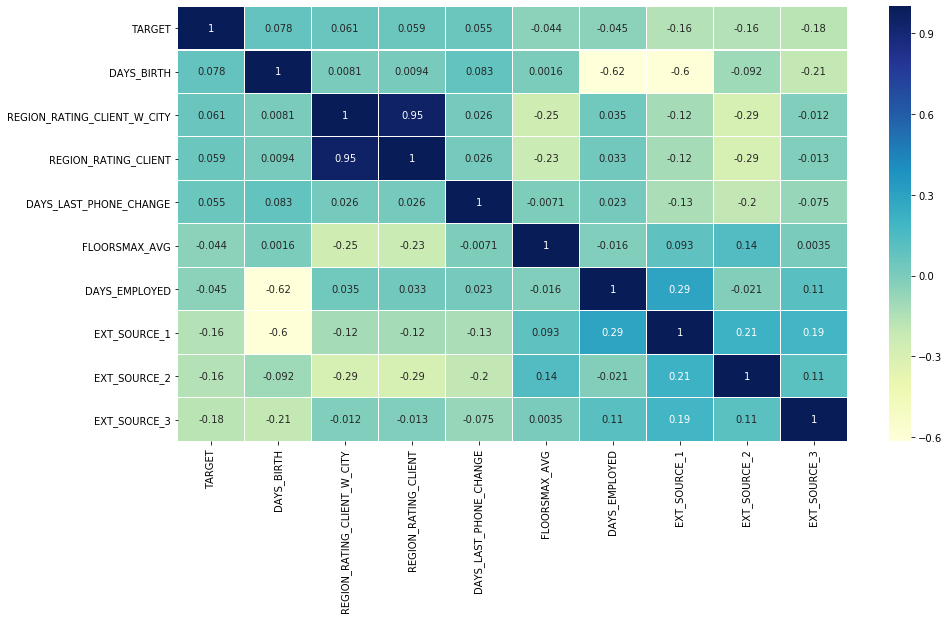

In [40]:
# Calculate correlations
corr = df_train_corr.corr()
# Heatmap
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True, linewidths=.2, cmap="YlGnBu")

# <a id='7'>7. Algorithms and Techniques</a>

In this section, we will need to discuss the algorithms and techniques we intend to use for solving the problem.

<a id='7-1'> 7.1 Benchmark: Logistic Regression </a>

In this section, we will provide a defined benchmark result or threshold for comparing across performances obtained by your solution.

Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. Logistic Regression is classification algorithm that is not as sophisticated as the ensemble methods or boosted decision trees method discussed previously. Hence, it provides us with a good benchmark. 

Binary logistic regression requires the dependent variable to be binary. For a binary regression, the factor level 1 of the dependent variable should represent the desired outcome. Also, the features should be independent of each other. The model should have little or no multicollinearity. 

<a id='7-2'>7.2 Light GBM</a>

Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm, used for ranking, classification and many other machine learning tasks.

Light GBM splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. So when growing on the same leaf in Light GBM, the leaf-wise algorithm can reduce more loss than the level-wise algorithm and hence results in much better accuracy which can rarely be achieved by any of the existing boosting algorithms.

Light GBM uses leaf wise splitting over depth wise splitting which enables it to converge much faster but also leads to overfitting. Key parameters in Light GBM are:

num_iterations: number of boosting iterations to be performed ; default=100; type=int
num_leaves : number of leaves in one tree ; default = 31 ; type =int
min_data_in_leaf : Min number of data in one leaf.
max_depth: Specify the max depth to which tree will grow. This parameter is used to deal with overfitting.
LightGBM can be implemented using the latest release on Microsoft's GitHub portal: https://github.com/Microsoft/LightGBM

# <a id='8'>8. Data Processing</a>

In [41]:
df_train = df_train.drop('TARGET', axis=1) # drop target variable from training dataset

In [42]:
df_full = df_train
df_full = df_full.drop('SK_ID_CURR', axis=1) # drop SK_ID_CURR variable
df_full.shape

(307511, 120)

In [43]:
print('Size of Full dataset df_full is: {}'.format( df_full.shape))

Size of Full dataset df_full is: (307511, 120)


<a id='8-1'> 8.1 Label Encoding and One-Hot Encoding </a>

Machine Learning algorithms can typically only have numerical values as their predictor variables. Hence Label Encoding and One Hot Encoding becomes necessary as they encode categorical labels with value between 0 and 1.

In [44]:
from sklearn.preprocessing import LabelEncoder
# Create a label encoder object
le = LabelEncoder()

In [45]:
# let's break down the columns by their type (i.e. int64, float64, object)
df_full.dtypes.value_counts()

float64    65
int64      39
object     16
dtype: int64

In [46]:
le_count = 0
for col in df_full.columns[1:]:
    if df_full[col].dtype == 'object':
        if len(list(df_full[col].unique())) <= 2:
            le.fit(df_full[col])
            df_full[col] = le.transform(df_full[col])
            le_count += 1
print('{} columns were label encoded.'.format(le_count))

2 columns were label encoded.


In [47]:
# convert rest of categorical variable into dummy
df_full = pd.get_dummies(df_full)

In [48]:
print('Size of Full Encoded Dataset', df_full.shape)

Size of Full Encoded Dataset (307511, 242)


<a id='8-2'> 8.2 Feature Engineering </a>

Feature Engineering is the process of creating the most useful features out of the data. Feature engineering typically involves both creating new features from the existing data, and feature selection by choosing only the most important features.

<a id='8-2-1'> 8.2.1 Features: FLAG_DOCUMENT </a>

The datasets features 20 variables related to whether a client has provided a particular form. Let's see if these variables can be dropped from the training dataset by looking at the correlation between the FLAG_DOCUMENT variables and the TARGET variable.

In [49]:
df_train['TARGET'] = target
df_doc_corr = df_train[['TARGET','FLAG_DOCUMENT_2','FLAG_DOCUMENT_3','FLAG_DOCUMENT_4',
                        'FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7','FLAG_DOCUMENT_8', 
                        'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 
                        'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
                        'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
                        'FLAG_DOCUMENT_21']].copy()

Looking at the correlation between the documents and the TARGET variables, the Top 4 documents that stand out as having correlations to be included in the training dataset: FLAG_DOCUMENT_3 at 0.044346, FLAG_DOCUMENT_6 at -0.028602, FLAG_DOCUMENT_16 at -0.011615, and FLAG_DOCUMENT_13 at -0.011583.

In [50]:
# Find correlations with the target and sort
correlations = df_doc_corr.corr()['TARGET'].sort_values()
print('Most Positive Correlations: \n', correlations.tail(5))
print('\nMost Negative Correlations: \n', correlations.head(5))

Most Positive Correlations: 
 FLAG_DOCUMENT_20    0.000215
FLAG_DOCUMENT_21    0.003709
FLAG_DOCUMENT_2     0.005417
FLAG_DOCUMENT_3     0.044346
TARGET              1.000000
Name: TARGET, dtype: float64

Most Negative Correlations: 
 FLAG_DOCUMENT_6    -0.028602
FLAG_DOCUMENT_16   -0.011615
FLAG_DOCUMENT_13   -0.011583
FLAG_DOCUMENT_14   -0.009464
FLAG_DOCUMENT_8    -0.008040
Name: TARGET, dtype: float64


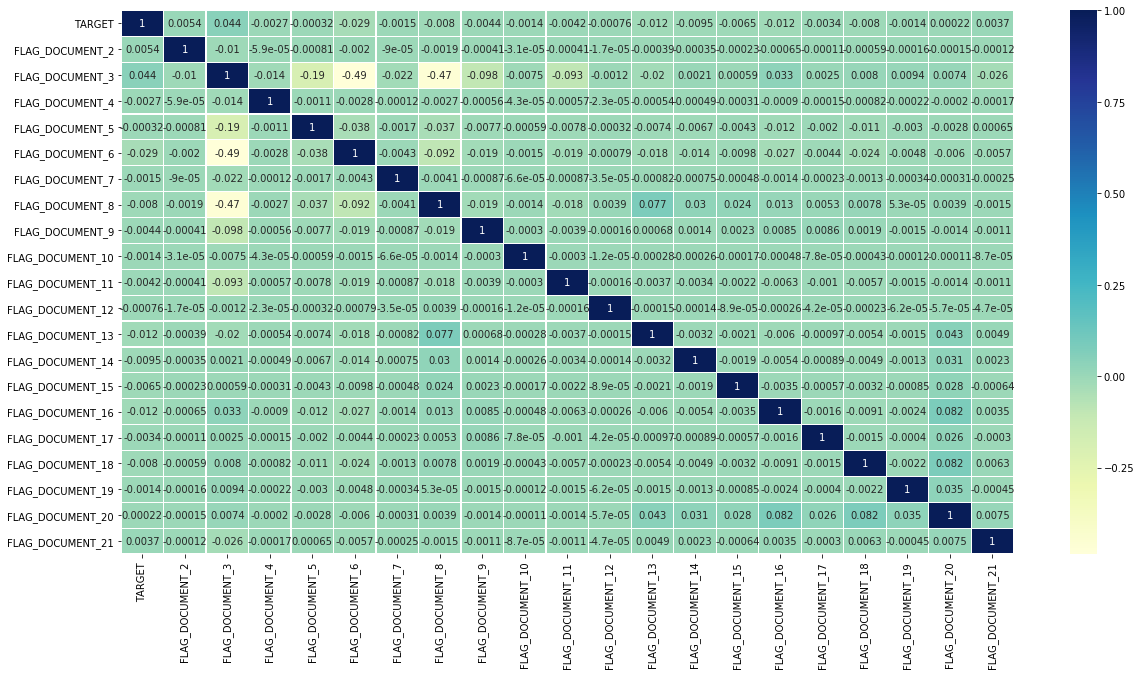

In [51]:
# Calculate correlations
corr = df_doc_corr.corr()
# Heatmap
plt.figure(figsize=(20,10))
sns.heatmap(corr, annot=True, linewidths=.2, cmap="YlGnBu");

Hence, we will only keep FLAG_DOCUMENT_3, FLAG_DOCUMENT_6, FLAG_DOCUMENT_13, and FLAG_DOCUMENT_16 in our training dataset and drop the other 16 FLAG_DOCUMENT features from the training dataset.

In [52]:
df_full = df_full.drop(['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 
                        'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 
                        'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 
                        'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15'], axis=1)

<a id='8-3'> 8.3 Missing Values and Feature Scaling </a>

In [53]:
def missing_val_ratio(df):
    perc_na = (df.isnull().sum()/len(df))*100
    ratio_na = perc_na.sort_values(ascending=False)
    missing_data_table = pd.DataFrame({'% of Total Values' :ratio_na})
    return missing_data_table

In [54]:
df_full_miss = missing_val_ratio(df_full)
df_full_miss.head(5)

,% of Total Values
COMMONAREA_AVG,69.872297
COMMONAREA_MODE,69.872297
COMMONAREA_MEDI,69.872297
NONLIVINGAPARTMENTS_MODE,69.432963
NONLIVINGAPARTMENTS_MEDI,69.432963


Looking at the distribution shown below, it is clear that quite a number of features have a non-negligible amount of missing values. We could either discard them or impute them (ie replace missing values) with another value such as the median or the mean for that particular feature.

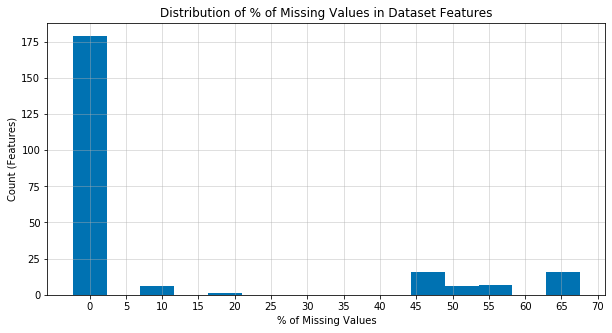

In [55]:
plt.figure(figsize=(10,5))
plt.style.use('seaborn-colorblind')
plt.grid(True, alpha=0.5)
x = df_full_miss['% of Total Values']
x.hist(align='left', bins= 15)
plt.xticks(np.arange(0, 75, 5))
plt.xlabel('% of Missing Values')
plt.ylabel('Count (Features)')
plt.title('Distribution of % of Missing Values in Dataset Features');
plt.show();

To improve the performance of the Machine Learning arlgorithms, we will keep all features and address the missing values by replacing them with the median value if the feature is numerical and with "N/A" if the feature is categorical. 

We will also normalize the range of the features to scale them between values 0 and 1. We will iterate through each column of the master dataframe df_full using sklearn's MinMaxScaler to scale the features.

In [56]:
from sklearn.preprocessing import MinMaxScaler, Imputer
imputer = Imputer(strategy = 'median') # Median imputation of missing values
scaler = MinMaxScaler(feature_range = (0, 1)) # Scale each feature to 0-1

/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [57]:
for column in df_full.columns:
    df_full[[column]] = imputer.fit_transform(df_full[[column]])
    df_full[[column]] = scaler.fit_transform(df_full[[column]])

After imputing and scaling, features such as AMT_INCOLE_TOTAL and AMT_CREDIT are scaled to values between 0 and 1, while feature values that were previously equal to 0 or 1 (as a result of encoding) remain unchanged from int to floating values. The transformed dataframe has 307,511 observations of 231 features. 

As shown below, we no longer have missing values in our dataframe.

In [60]:
df_full_miss = missing_val_ratio(df_full)
df_full_miss.head(5)

,% of Total Values
EMERGENCYSTATE_MODE_Yes,0.0
FLAG_DOCUMENT_18,0.0
FLAG_DOCUMENT_16,0.0
FLAG_DOCUMENT_13,0.0
FLAG_DOCUMENT_6,0.0


# <a id='9'>9. Results</a>

<a id='9-1'> 9.1 Data Preparation  </a>

Firslty, prior to implementating or applying any Machine Learning algorithms, we must decouple training and testing datasets from our master dataframe.

In [62]:
df_full.shape

(307511, 231)

In [63]:
# create train and validations dataset from train 
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(df_full, target, test_size = 0.2, random_state = 0)

In [64]:
xTrain.shape, xTest.shape, yTrain.shape, yTest.shape

((246008, 231), (61503, 231), (246008,), (61503,))

The final training set consists of 246, 008 obersations of 231 features while the testing set is made up of 61, 503 observations of 231 features.

<a id='9-2'> 9.2 Logistic Regression  </a>

Let's first apply the Logistic Regression algorithm as a baseline for our more sophisticated solutions later on. We will use default values as provided by sklearn's library.

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
# Make the model with the specified regularization parameter
log_reg = LogisticRegression(random_state = 42)
# Train on the training data
log_reg.fit(xTrain, yTrain)
log_reg_predict = log_reg.predict(xTest)
roc_auc_score(yTest, log_reg_predict)

0.5054965958859751

In [66]:
from collections import Counter
Counter(log_reg_predict)

Counter({0: 61391, 1: 112})

<a id='9-3'> 9.3 Light GBM </a>

Finally, we'll apply our last algorithm: Light GBM which should yield a better score in its predictions than Logistic Regression and Random Forest. We will use default values as provided by Light GBM's library.

In [67]:
from lightgbm import LGBMClassifier
LGB_clf = LGBMClassifier(n_estimators=100, 
                         boosting_type='gbdt', 
                         objective='binary', 
                         metric='binary_logloss')
LGB_clf.fit(xTrain, yTrain)
LGB_clf_pred = LGB_clf.predict_proba(xTest)[:, 1]

Once again, for this initial run, the alogorithm was run with default values. Key hyper-parameters for LightGBM include num_leaves (set the number of leaves to be formed in a tree, default = 31), min_data_in_leaf (minimum data points in a leaf, default = 20), max_depth (maximum depth or level up to which tree can grow), and num_iterations (number of boosting iterations, default = 100) amongst others.

The model was fitted to the training and target data, and used to make predictions for the testing dataset xTest.

In [74]:
LGB_clf_pred_binary = np.where(LGB_clf_pred > 0.5, 1, 0)

In [75]:
Counter(LGB_clf_pred_binary)

Counter({0: 61346, 1: 157})

In [77]:
roc_auc_score(yTest, LGB_clf_pred_binary)

0.5083419846353457

# <a id='10'>10. Model Tuning</a>